In [3]:
import xarray as xr
from matplotlib import pyplot as plt, cm, colors
import cartopy.crs as ccrs
import numpy as np
import scipy as sp
import warnings
import networkx as nx
import os
import glob
import pandas as pd
import seaborn as sb
import itertools as it
from ipyleaflet import Map, basemaps, basemap_to_tiles, Circle, WidgetControl, \
                        Velocity, Polyline, Marker, Polygon, GeoData, \
                        LayersControl, LayerGroup
from ipywidgets import SelectionSlider, IntSlider, Play, HBox, VBox, jslink, Text, HTML, Layout
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from geopy.distance import geodesic, lonlat
import geog
from shapely import geometry
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
import geopandas as gpd
from geovoronoi import voronoi_regions_from_coords, plotting

In [20]:
def add_coords_to_xr(f):
    ds = xr.open_dataset(f)
    ds = ds.expand_dims({'latitude': [ds.latitude], 
                         'longitude':[ds.longitude]})
    return ds

def get_coords(f):
    ds = xr.open_dataset(f)
    return (ds.longitude, ds.latitude)

def get_name(f):
    ds = xr.open_dataset(f)
    return ds.source

def to_latlon(coords):
    return (coords[1], coords[0])

def resample(f, start, end, var, unit, mask_days):
    ds = xr.open_dataset(f)
    if mask_days:
        # only keep data at times between civil dusk and dawn (6 degrees below horizon)
        ds = ds.where(ds.solarpos < -6)
    ds = ds.sel(time=slice(start,end))[var]
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='Mean of empty slice')
        ds = ds.resample(time=unit, skipna=True).reduce(np.nanmean)
    t_range = pd.date_range(start, end, freq=unit)
    ds = ds.reindex({'time': t_range})
    return ds
    
def load_data(path, var='vid', start=None, end=None, t_unit='1H', mask_days=True):
    files = glob.glob(os.path.join(path,'*.nc'))
    data = {get_coords(f) : resample(f, start, end, var, t_unit, mask_days) for f in files} 
    names = {get_coords(f): get_name(f) for f in files}
    t_range = pd.date_range(start, end, freq=t_unit)
    return data, names, t_range

def arr(xarray_1d):
    return np.array(xarray_1d).flatten()
    

def plot_all_vpts(data, names, t_range, bar=False):
    #data, names, t_range = load_data(path, var, start, end, t_unit)
    
    fig, ax = plt.subplots(len(data),1,figsize=(15,2*len(data)), sharex=True)
    for i, (coord, ds) in enumerate(data.items()):
        ds_arr = arr(ds)
        
        if bar:
            barwidth = 0.95 * (1 / t_range.shape[0])
            ax[i].bar(t_range, ds_arr, barwidth)
        else:
            ax[i].plot(t_range, ds_arr)
            
        missing = (np.where(np.isnan(ds_arr))[0].size/ds_arr.size)*100
        
        ax[i].text(*(.98, .95), f'{names[coord]} [{missing:.0f}% missing]',  
                   horizontalalignment = 'right', va = "top",
                   transform = ax[i].transAxes, fontsize=12)
    plt.subplots_adjust(hspace=0)

### Partition of Space - The Voronoi Diagram

In [5]:
class Spatial:
    def __init__(self, radars, epsg='4326', epsg_local='3035'):
        """
        Initialization of Spatial object
        Args:
            radars (dict): mapping from radar coordinates (lon, lat) to names
            epsg (str): coordinate reference system as epsg string 
            epsg_local (str): coordinate reference system as epsg string 
        """
        self.radars = radars
        self.epsg = epsg
        self.epsg_local = epsg_local
        self.N = len(radars)
        
        # projection to local crs
        self.pts_lonlat = gpd.GeoSeries([Point(xy) for xy in radars.keys()], 
                            crs=f'EPSG:{epsg}')
        self.pts_local = self.pts_lonlat.to_crs(epsg=epsg_local)
        
    
    def voronoi(self, buffer=150_000, plot=False):
        """
        Construct Voronoi diagram based on radar coordinates
        Args:
            buffer (float): max distance around radar stations (in meters)
            plot (bool): if True, plot Voronoi diagram
        Returns:
            adj (GeoDataFrame): edges between neighbouring radars, weight=distance [m]
            cells (GeoDataFrame): polygons describing the Voronoi cells
        """
        coords = self.pts2coords(self.pts_local)
        boundary = MultiPoint(self.pts_local).buffer(buffer)
        polygons, pts, poly2pt = voronoi_regions_from_coords(coords, boundary)
        
        idx = np.array(poly2pt).flatten().argsort()       
        cells = gpd.GeoSeries(np.array(polygons)[idx], 
                                   crs=f'EPSG:{self.epsg_local}')
        
        adj = np.zeros((self.N, self.N))
        edges = []
        for i, j in it.combinations(cells.index, 2):
            intersec = cells.iloc[i].intersection(cells.iloc[j])
            if type(intersec) is geometry.LineString:
                adj[i,j] = self.distance(coords[i], coords[j], 
                                           epsg=self.epsg_local)
                adj[j,i] = adj[i,j]
                edges.append(geometry.LineString((coords[i], coords[j])))
                
        self.cells = cells
        self.adj = adj
        self.max_dist = np.max(adj)
        self.edges = gpd.GeoSeries(edges, crs=f'EPSG:{self.epsg_local}')
        
        if plot:
            fig, ax = plotting.subplot_for_map(figsize=(7,7))
            plotting.plot_voronoi_polys_with_points_in_area(ax, 
                        boundary, polygons, coords, poly2pt)
            self.edges.plot(ax=ax)
            plt.show()
            
        return adj, cells
        
        
    def pts2coords(self, pts, reverse_xy=False):
        """
        Convert point objects to [x, y] coordinates
        Args:
            reverse_lonlat (bool): if true, the order of the two coordinates is switched 
        Returns:
            coords: np.array of projected coordinates
        """
        coords = np.array([[p.xy[0][0], p.xy[1][0]] for p in pts])
        if reverse_xy: 
            coords = np.flip(coords, axis=1)
        return coords
    
    
    def distance(self, coord1, coord2, epsg):
        """
        Compute distance between two geographical locations
        Args:
            coord1 (tuple): coordinates of first location (lon, lat) or (x, y)
            coord2 (tuple): coordinates of second location (lon, lat) or (x, y)
        Returns:
            dist (float): distance in meters
        """
        if epsg == self.epsg_local:
            dist = np.linalg.norm(np.array(coord1)-np.array(coord2))
        elif epsg == '4326':
            dist = geodesic(self.flip(coord1), self.flip(coord2)).meters
        else:
            dist = None # raise error?
        return dist
            
    
    def flip(self, coord):
        return (coord[1], coord[0])

### Visualization

In [6]:
def construct_circle(coord, data, time):
    circle = Circle()
    circle.location = to_latlon(coord)
    circle.radius = 25*1000 # [in meters]
    circle.stroke = False
    circle.fill_opacity = 1
    
    d = data.sel(time=time, 
                 lon=coord[0],
                 lat=coord[1])
    
    c = colors.rgb2hex(cmap(norm(d)))
    circle.color = 'gray'
    circle.fill_color = c
    
    return circle

def construct_arrow(coord, data, time):
    lon = coord[0]
    lat = coord[1]
    
    s = 0.1
    u = s * float(data.sel(time=time, lon=lon, lat=lat).u)
    v = s * float(data.sel(time=time, lon=lon, lat=lat).v)

    norm = np.linalg.norm([2*v, u])*5
    norm = np.linalg.norm([2*v, u])
    u_n = u/(norm*5)
    v_n = v/(norm*5)
    line = Polyline(
        locations=[
            [lat-v_n, lon-u_n],
            [lat+v_n, lon+u_n]
        ],
        color="green" ,
        fill=False,
        #line_cap='square',
        weight = int(1+ np.nan_to_num(norm)*3)
    )
    
    s_head = 0.1 
    polygon = Polygon(
        locations=[
            [lat+v_n-u*s_head, lon+u_n+2*v*s_head], 
            [lat+v_n+v*s_head, lon+u_n+u*s_head],
            [lat+v_n+u*s_head, lon+u_n-2*v*s_head]
        ],
        color="green",
        fill_color="green",
        fill_opacity = 1,
        weight = 1
    )
    
    return line, polygon

### Correlations

In [32]:
def all_data(data):
    all_data = []
    for c, d in data.items():
        all_data.append(np.array(d))
    all_data = np.concatenate(all_data)
    return all_data

def angle_from_latlon(lon1, lat1, lon2, lat2):
    
    y = lon1-lon2
    x = lat1-lat2

    brng = np.arctan2(y, x)
    brng = np.rad2deg(brng)
    brng = (brng + 360) % 360

    return brng

def compute_corr(x, y, lag):
    if lag > 0:
        x = x[:x.size-lag]
        y = y[lag:]
    else:
        x = x[-lag:]
        y = y[:y.size+lag]
    
    x_mask = np.isfinite(x)
    y_mask = np.isfinite(y)
    xy_mask = np.logical_and(x_mask, y_mask)

    x = x[xy_mask]
    y = y[xy_mask]

    r, p = sp.stats.pearsonr(x, y)
    
    return r, p
    

def corr(data, names, lag, neighbours_only=False):
    dist_lon = []
    dist_lat = []
    dist = []
    angle = []
    pearsonr = []
    
    spatial = Spatial(names)
    adj, _ = spatial.voronoi()
    mapping = {ci : idx for idx, ci in enumerate(names.keys())}
    for ci, cj in it.permutations(names.keys(), 2):
        d = geodesic(lonlat(*ci), lonlat(*cj)).kilometers
        if neighbours_only:
            cond = (adj[mapping[ci], mapping[cj]] > 0)
        else:
            cond = True
        if cond:
            dist_lon.append(cj[0]-ci[0])
            dist_lat.append(cj[1]-ci[1])
            dist.append(d)
            angle.append(np.abs(angle_from_latlon(*cj, *ci))) # from ci to cj
            
            # corr of earlier time point at ci with later time point at cj
            x = np.array(data[ci]).flatten()
            y = np.array(data[cj]).flatten()
            
            r, p = compute_corr(x, y, lag)
            
            pearsonr.append(r)
        
    fig, ax = plt.subplots(1, 2, figsize=(12,3))
    
    #ax[0].scatter(angle, pearsonr, c=dist)
    #ax[2].scatter(dist_lat, pearsonr, c=dist)
    #ax[2].scatter(dist, pearsonr)
    #ax[0].set_xlabel('angle')
    #ax[2].set_xlabel('lat diff')
    #ax[2].set_xlabel('dist')
    #ax[2].axvline(dist_lat[np.argmax(pearsonr)], ls = '--')
    
    if neighbours_only:
        bins = np.linspace(-1.5, 1.5, 4)
    else:
        bins = np.linspace(-5.5, 5.5, 12)
    A = np.vstack((np.digitize(dist_lat, bins), pearsonr)).T
    means = [np.mean(A[A[:, 0] == i, 1]) for i in range(len(bins))]
    std = [np.std(A[A[:, 0] == i, 1]) for i in range(len(bins))]
    maxr = [np.max(A[A[:, 0] == i, 1]) for i in range(len(bins))]
    #ax[3].errorbar(bins-(bins[1]-bins[0])/2, means, std)
    #ax[3].plot(bins-(bins[1]-bins[0])/2, maxr)
    
    binsize = (bins[1]-bins[0])/2
    binc = bins - binsize
    binc = np.append(binc, bins[-1]+binsize)
    lats = [binc[i] for i in np.digitize(dist_lat, bins)]
    df = pd.DataFrame({'corr' : pearsonr, 'lat diff' : lats})
    ax[0].axvline(int(bins.size/2), ls = '--', c='lightgray')
    ax[0] = sb.boxplot(x="lat diff", y="corr", data=df, color='gray', ax=ax[0])
    ax[0].set_ylim(0,1)
    ax[0].set_title(f'Lag = {lag}h')
    
    if neighbours_only:
        bins = np.linspace(0, 360, 9)[1:]
    else:
        bins = np.linspace(0, 360, 17)[1:]
    A = np.vstack((np.digitize(angle, bins), pearsonr)).T
    means = np.array([np.mean(A[A[:, 0] == i, 1]) for i in range(len(bins))])
    std = np.array([np.std(A[A[:, 0] == i, 1]) for i in range(len(bins))])
    maxr = [np.nanmax(A[A[:, 0] == i, 1]) for i in range(len(bins))]
    #ax[1].errorbar(bins-(bins[1]-bins[0])/2, means, std)
    #ax[1].plot(bins-(bins[1]-bins[0])/2, maxr)
    
    binsize = (bins[1]-bins[0])/2
    binc = bins - binsize
    binc = np.append(binc, bins[-1]+binsize)
    angles = np.array([binc[i] for i in np.digitize(angle, bins)])
    angles = angles/360 * 2*np.pi
    df = pd.DataFrame({'corr' : pearsonr, 'angle' : angles})
    #ax[1] = sb.boxplot(x="angle", y="corr", data=df, color='gray', ax=ax[1])

    ax[1].remove()
    x = (bins-(bins[1]-bins[0])/2)/360 *2*np.pi
    axis = fig.add_subplot(1, 2, 2, projection='polar')
    bars = axis.bar(x, means, width=0.3, bottom=0, yerr=std, ecolor='gray')
    #bars = axis.errorbar(bins-(bins[1]-bins[0])/2, means, std)
    #x = (bins-(bins[1]-bins[0])/2)/360 *2*np.pi
    #axis.plot(x, means, c='blue')
    #axis.fill_between(x, means-std, means+std,
    #       alpha=0.5, edgecolor='blue', facecolor='blue')
    
    # Use custom colors and opacity
    for r, bar in zip(means, bars):
        bar.set_facecolor(plt.cm.jet(r))
        #bar.set_alpha(1)
    
    axis.set_rlim(0,1)
    axis.set_theta_zero_location("N")
    axis.set_theta_direction(-1)

def corr_neighbours(data, names, lags, neighbours_only=True):
    
    rows = []
    
    if neighbours_only:
        bins_lat = np.linspace(-1.5, 1.5, 4)
    else:
        bins_lat = np.linspace(-5, 5, 6)

    bins_angle = np.linspace(0, 360, 9)[1:]
    
    def binc(bins):
        binsize = (bins[1]-bins[0])/2
        binc = np.append(bins-binsize, bins[-1]+binsize)
        return binc
    
    spatial = Spatial(names)
    adj, _ = spatial.voronoi()
    mapping = {ci : idx for idx, ci in enumerate(names.keys())}
    for ci, cj in it.permutations(names.keys(), 2):
        if neighbours_only:
            cond = (adj[mapping[ci], mapping[cj]] > 0)
        else:
            cond = True
        if cond:
            for lag in lags:
                x = np.array(data[ci]).flatten()
                y = np.array(data[cj]).flatten()

                r, p = compute_corr(x, y, lag)
                rows.append({'diff lat': binc(bins_lat)[np.digitize(cj[1]-ci[1], bins_lat)], 
                             'diff lon': binc(bins_lon)[np.digitize(cj[0]-ci[0], bins_lon)],
                             'angle': binc(bins_angle)[np.digitize(np.abs(angle_from_latlon(*cj, *ci)), bins_angle)]/360*2*np.pi,
                             'lag': lag, 
                             'corr': r})
                
    df = pd.DataFrame(rows)
        
    fig, ax = plt.subplots(1, 1, figsize=(18,3))
    ax= sb.boxplot(x="lag", y="corr", data=df, hue="diff lat", ax=ax)
    ax.set_ylim(0,1)
    ax.legend(loc='upper center', title='difference in latitude [deg]', bbox_to_anchor=(0.5, 1.3), ncol=len(lags)+1)

    fig, ax = plt.subplots(1, len(lags), figsize=(18,3), subplot_kw = {'projection' : 'polar'})
    for i, lag in enumerate(lags):
        df_lag = df[df.lag==lag]
        df_lag = df_lag.groupby('angle')
        
        #x = (bins_angle-(bins_angle[1]-bins_angle[0])/2)/360 *2*np.pi
        means = df_lag.mean()['corr']
        bars = ax[i].bar(df_lag.mean().index, means, width=0.3, bottom=0, yerr=df_lag.std()['corr'], ecolor='gray')
        for r, bar in zip(means, bars):
            bar.set_facecolor(plt.cm.jet(r))

        ax[i].set_rlim(0,1)
        ax[i].set_theta_zero_location("N")
        ax[i].set_theta_direction(-1)
    plt.subplots_adjust(wspace=0.5)
    
def spatio_temp_corr(rcode, data, names, lags):

    coord_list = list(names.keys())
    names_list = np.array(list(names.values()))
    
    spatial = Spatial(names)
    adj, _ = spatial.voronoi()
    mapping = {ci : idx for idx, ci in enumerate(names.keys())}

    ci = {v:k for k,v in names.items()}[rcode]
    di = data[ci]
    sorted_radars = dict(sorted(names.items(), key=lambda x: geodesic(lonlat(*ci), lonlat(*x[0])).kilometers))
    corr = []
    codes = []
    for cj in list(sorted_radars.keys()):
        if adj[mapping[ci], mapping[cj]] > 0:
            codes.append(f'** {names[cj]}')
        else:
            codes.append(names[cj])
        corr.append([])
        for lag in lags:
            x = np.array(data[ci]).flatten()
            y = np.array(data[cj]).flatten()
            
            r, p = compute_corr(x, y, lag)
            corr[-1].append(r)

    fig, ax = plt.subplots(figsize=(10,5))
    sb.heatmap(pd.DataFrame(corr), cmap='RdBu_r', ax=ax)
    ax.set(title=rcode, xlabel='Lag [hours]',ylabel='Radars')
    ax.set_yticklabels(codes, rotation=0)
    ax.set_xticklabels(np.array(lags))


### Load Vertical Profile Data - Autumn 2016

In [44]:
path = '/home/fiona/radar_data/vpi/night_only/20160801T0000_to_20161130T2359'
begin = '2016-09-01'
end = '2016-11-01'
begin = '2016-10-04'
end = '2016-10-06'

vid_data, names, t_range = load_data(path, 'vid', begin, end, '1H', mask_days=True)
uv_data, _, _ = load_data(path, ['u', 'v'], begin, end, '1H')
ff_data, _, _ = load_data(path, 'ff', begin, end, '1H')

### Time Series Inspection

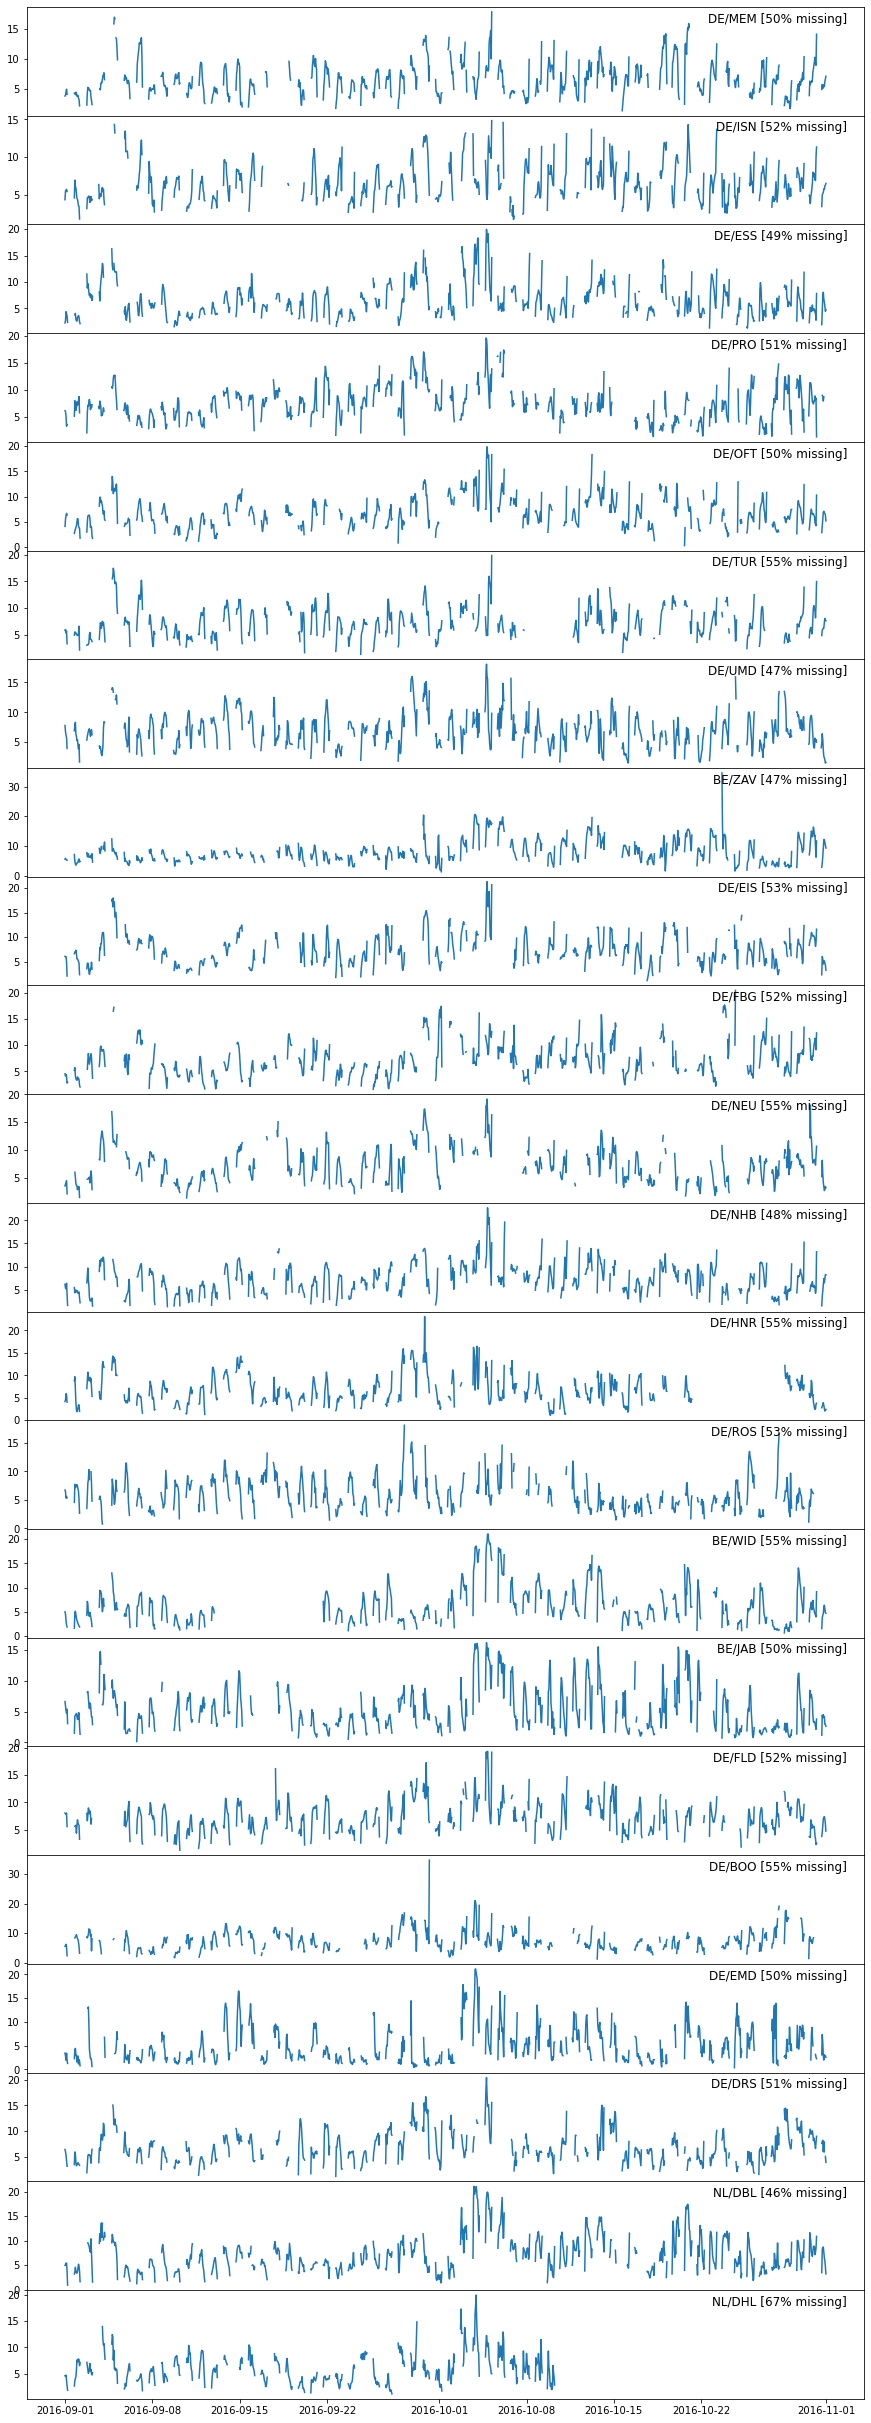

In [208]:
plot_all_vpts(ff_data, names, t_range, bar=False)

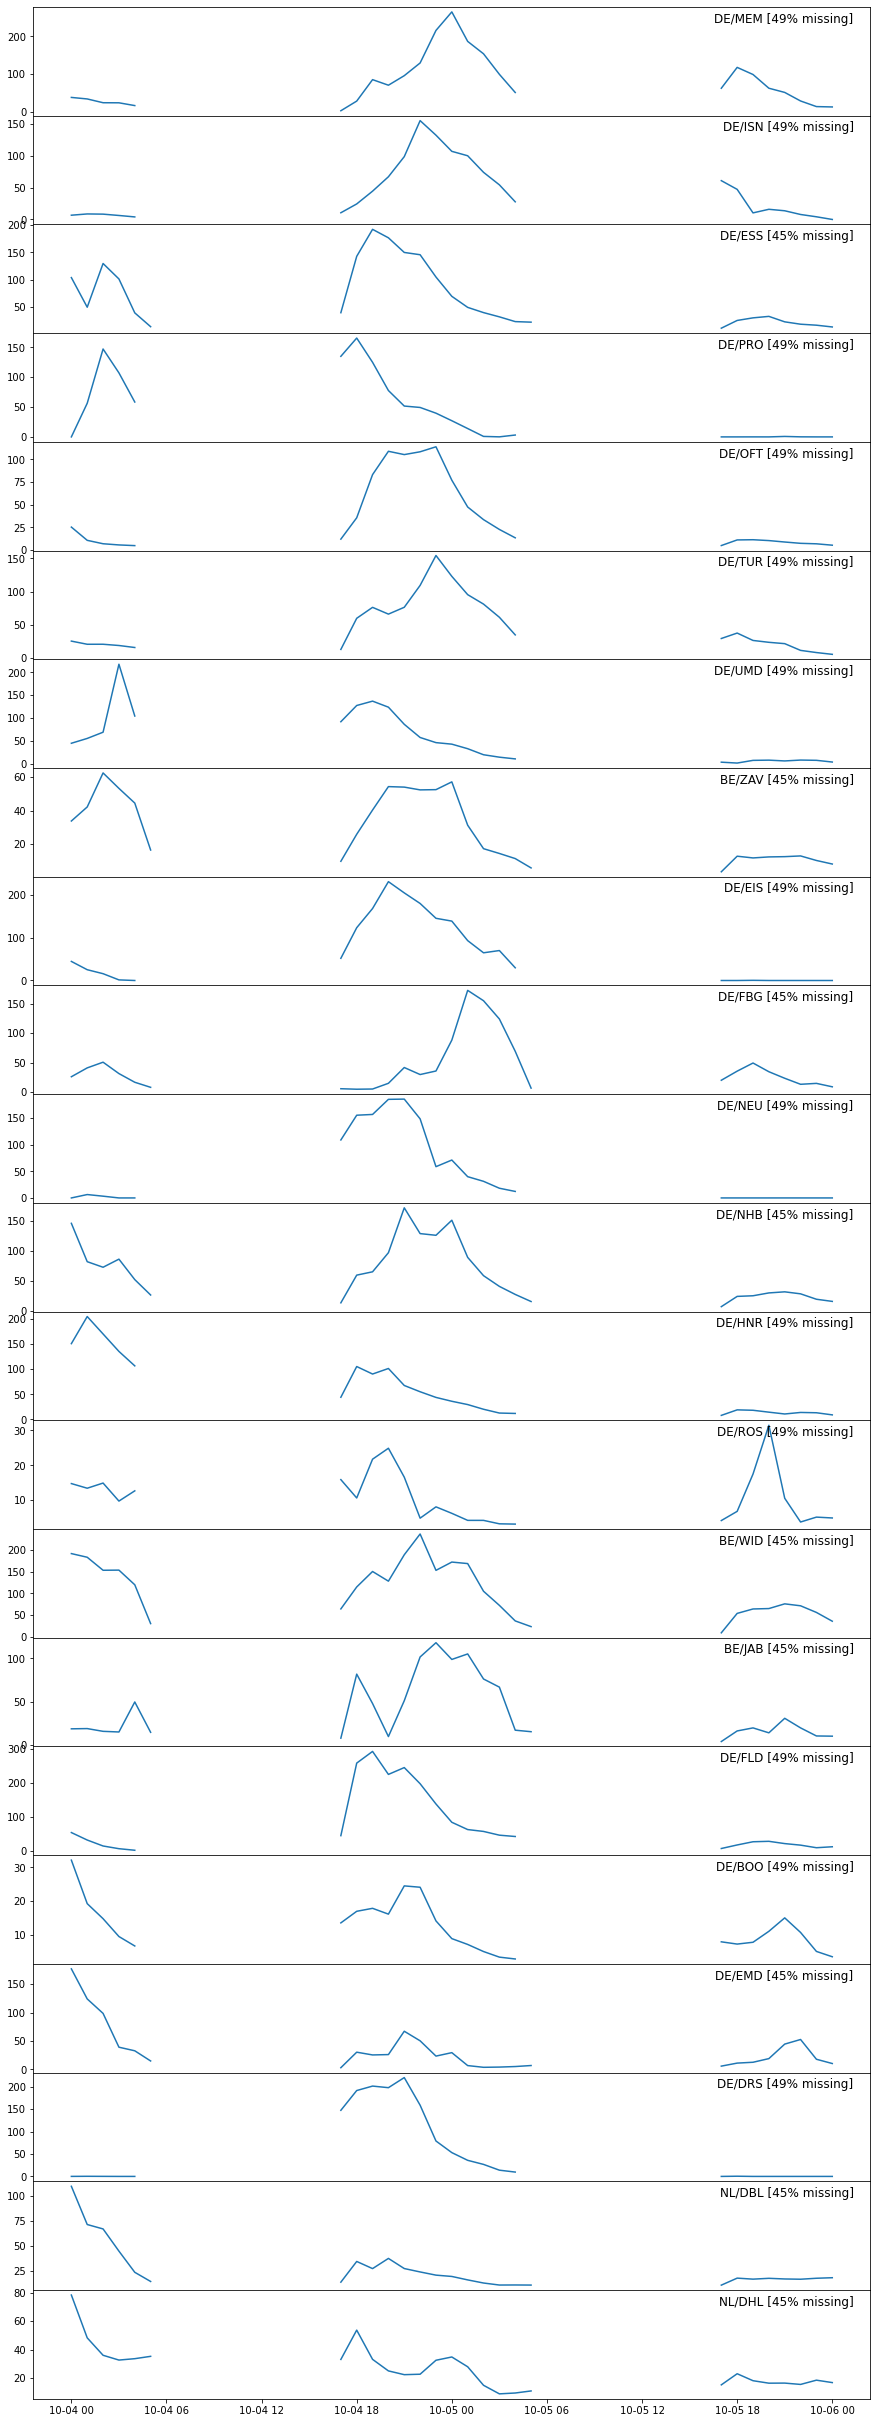

In [45]:
plot_all_vpts(vid_data, names, t_range, bar=False)

### Visualization

In [34]:
cmax = 200
cmap = cm.get_cmap('YlOrRd')
norm = colors.Normalize(vmin=0.,vmax=cmax)
#norm = colors.LogNorm(vmin=0.,vmax=500)


m = Map(center=(51, 10), zoom=6)
m.layout.height = '600px'


spatial = Spatial(names)
spatial.voronoi()
edges = spatial.edges.to_frame(name='geometry').to_crs(epsg=spatial.epsg)
edges = GeoData(geo_dataframe = edges, name='connections',
        style={'color': 'gray', 'opacity':0.8, 'weight':2, 'dashArray':'2 4'})
m.add_layer(edges)

cells = spatial.cells.to_frame(name='geometry').to_crs(epsg=spatial.epsg)
cells = GeoData(geo_dataframe = cells, name='cells',
        style={'color': '#336699', 'opacity':0.8, 'fill_opacity':0.1, 'weight':2})
m.add_layer(cells)


markers = {}
info = {}
lines = {}
arrow_heads = {}
for coord in vid_data.keys():
    markers[coord] = construct_circle(coord, vid_data[coord], str(t_range[0]))
    
    info[coord] = Marker(location=to_latlon(coord), 
                  draggable=False, 
                  title=names[coord], 
                  opacity=0)
    
    lines[coord], arrow_heads[coord] = construct_arrow(coord, 
                                        uv_data[coord], str(t_range[0]))
    
all_info = LayerGroup(layers=tuple(info.values()), name='info')
all_markers = LayerGroup(layers=tuple(markers.values()), name='markers')
arrows = tuple(lines.values())+tuple(arrow_heads.values())
all_arrows = LayerGroup(layers=arrows, name='arrows')

layer_control = LayersControl(position='topright')
m.add_control(layer_control)
m.add_layer(all_info)
m.add_layer(all_markers)
m.add_layer(all_arrows)



slider = IntSlider(description='time step:', 
                    value=0,
                    min=0,
                    max= len(t_range)-1,
                    step=1,
                    orientation='horizontal',
                    layout={'width': '500px'}
)
time_info = Text(value=str(t_range[slider.value]),
                    description='Datetime:'
)
play = Play(max = len(t_range) - 1, interval=500)
jslink((play, 'value'), (slider, 'value'))
widget_control = WidgetControl(widget=HBox([play, slider, time_info]), 
                               position='topright')
m.add_control(widget_control)

legend = {int(val) : colors.rgb2hex(cmap(norm(val))) for val in np.linspace(0, cmax, 6)}
layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    width='70px')

v = lambda val: f'''
<div style="width:25px;height:25px;background-color:{legend[val]};
display:inline-block;"></div>
<div style="width:35px;height:25px;display:inline-block; text-align:right;
position:absolute;top: 0%;">{val}</div>'''

legend = [HTML(value='<b>Birds/km2</b>')]+[HTML(value= v(val))for val in legend.keys()]
legend = WidgetControl(widget=HBox(legend, layout=layout), position='bottomright')
m.add_control(legend)

def update(change):
    for coord, data in vid_data.items():
        time = str(t_range[slider.value])
        vid = data.sel(time=time, lon=coord[0], lat=coord[1])
        if np.isfinite(float(vid)):
            c = colors.rgb2hex(cmap(norm(vid)))
            markers[coord].fill_color = c
            markers[coord].fill_opacity = 1
        else:
            markers[coord].fill_opacity = 0
        
        uv = uv_data[coord].sel(time=time, lon=coord[0], lat=coord[1])
        if np.isfinite(float(uv.u)) and np.isfinite(float(uv.v)):
            line, polygon = construct_arrow(coord, uv_data[coord], time)
            lines[coord].locations = line.locations
            lines[coord].weight = line.weight
            arrow_heads[coord].locations = polygon.locations
            arrow_heads[coord].fill_opacity = 1
            arrow_heads[coord].opacity = 1
        else:
            arrow_heads[coord].fill_opacity = 0
            arrow_heads[coord].opacity = 0
            lines[coord].weight = 0
        
    time_info.value = str(t_range[slider.value])

slider.observe(update, 'value')
display(m)

Map(center=[51, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Cross-Correlation with Varying Time-Lag

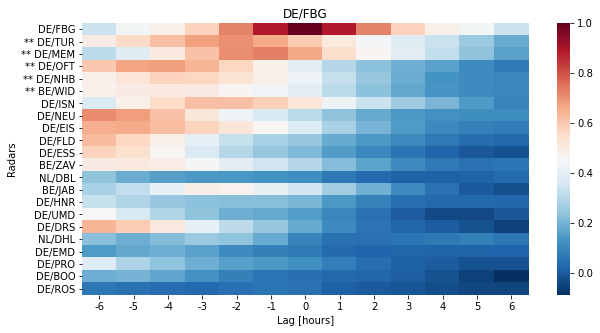

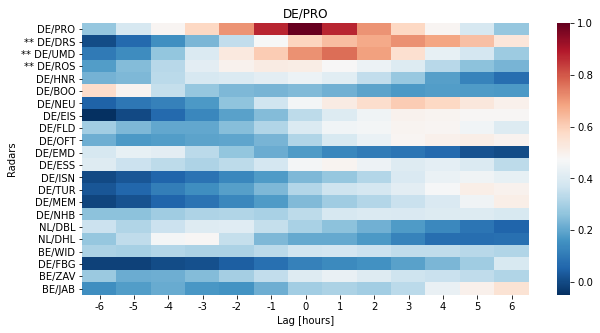

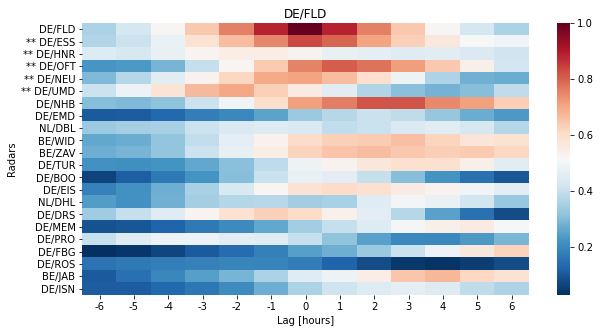

In [33]:
lags = range(-6,7)
spatio_temp_corr('DE/FBG', vid_data, names, lags=lags)
spatio_temp_corr('DE/PRO', vid_data, names, lags=lags)
spatio_temp_corr('DE/FLD', vid_data, names, lags=lags)

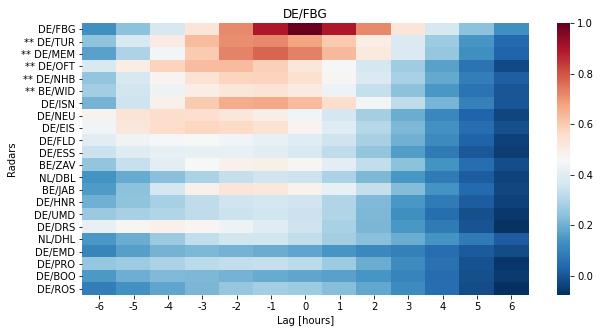

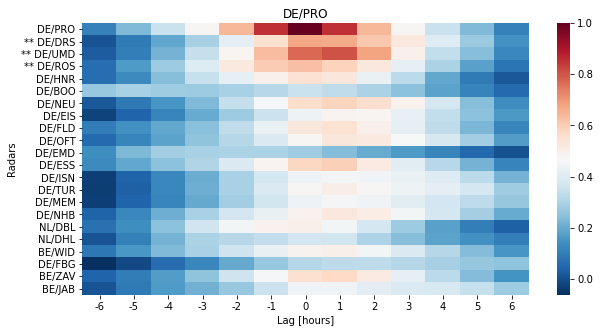

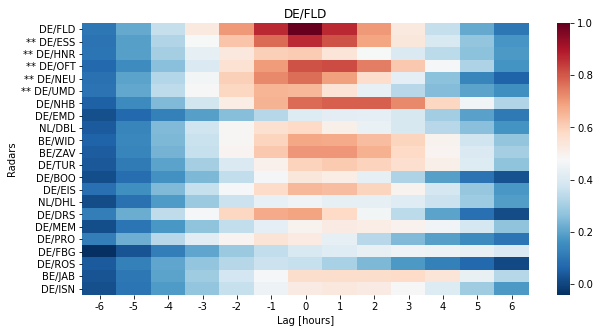

In [200]:
lags = range(-6,7)
spatio_temp_corr('DE/FBG', vid_data, names, lags=lags)
spatio_temp_corr('DE/PRO', vid_data, names, lags=lags)
spatio_temp_corr('DE/FLD', vid_data, names, lags=lags)

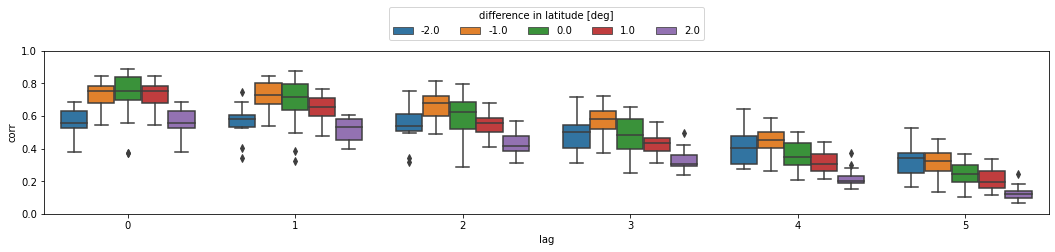

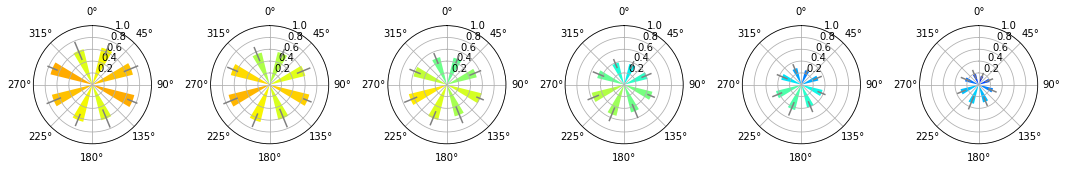

In [197]:
corr_neighbours(vid_data, names, range(6))

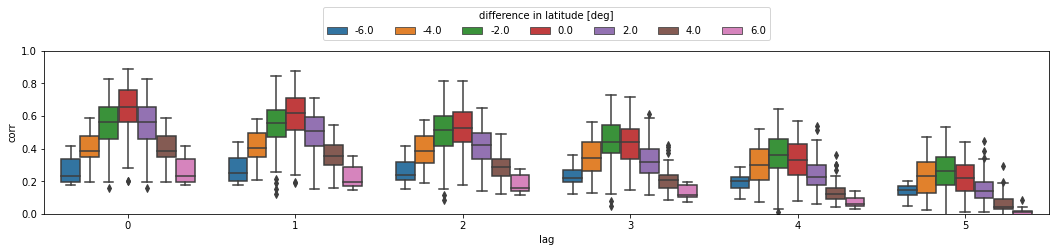

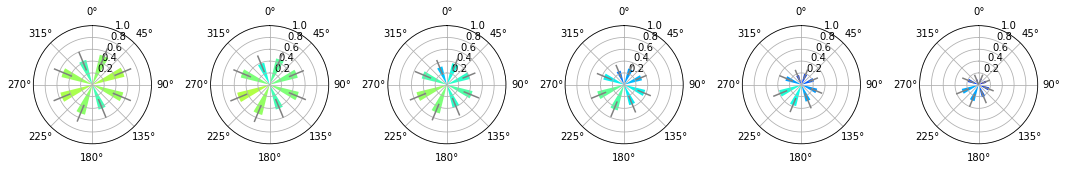

In [198]:
corr_neighbours(vid_data, names, range(6), neighbours_only=False)

**Relation Between cross-correlation and distance/angle for all pairs of radar stations**

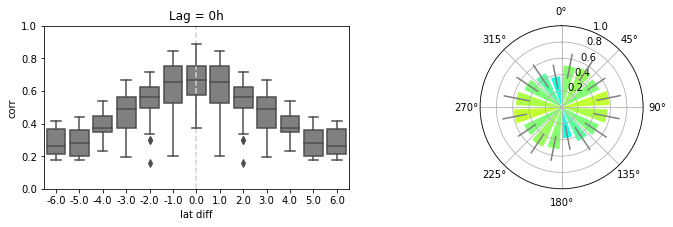

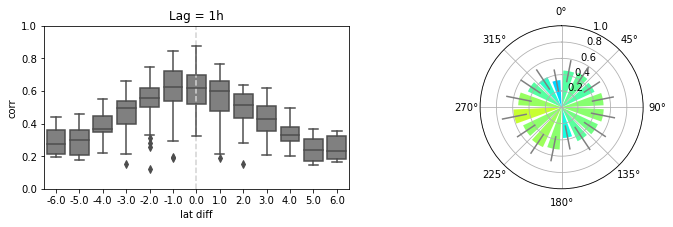

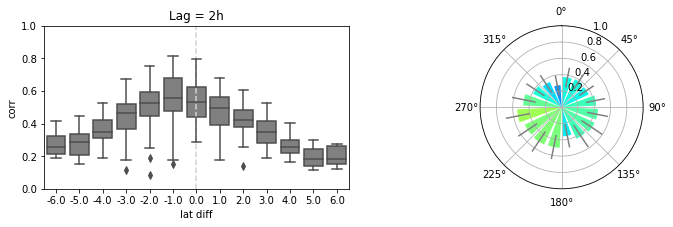

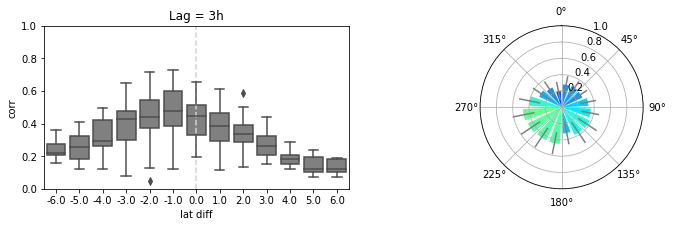

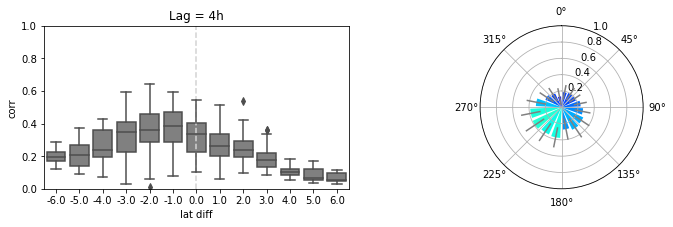

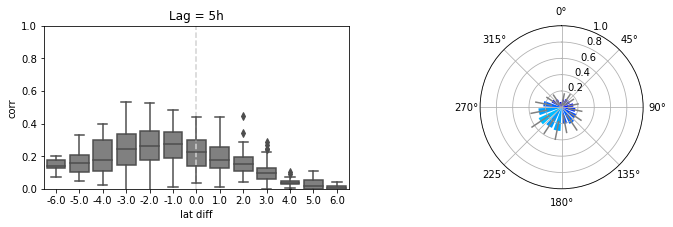

In [110]:
for lag in range(6):
    corr(vid_data, names, lag)

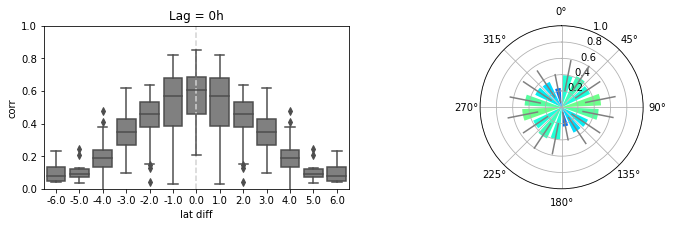

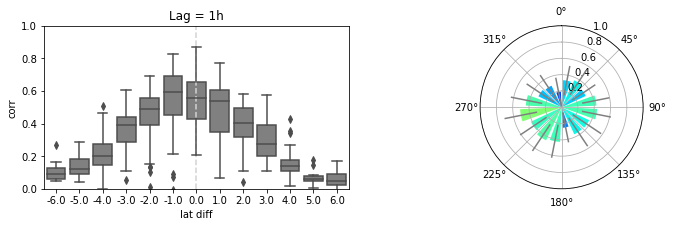

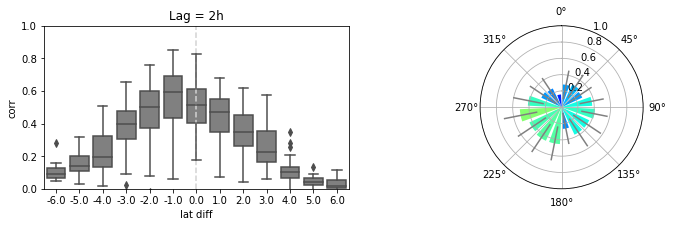

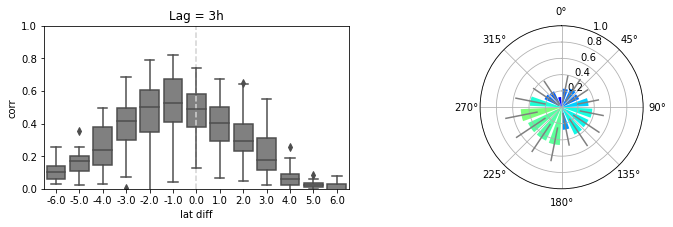

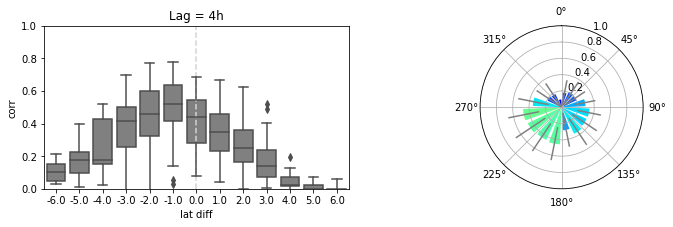

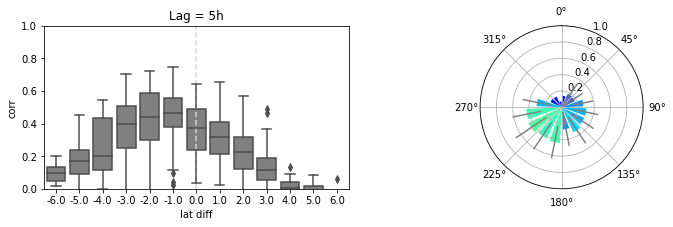

In [24]:
for lag in range(6):
    corr(vid_data, names, lag)

**Relation Between cross-correlation and distance/angle for neighbouring radar stations (in Voronoi Diagram)**

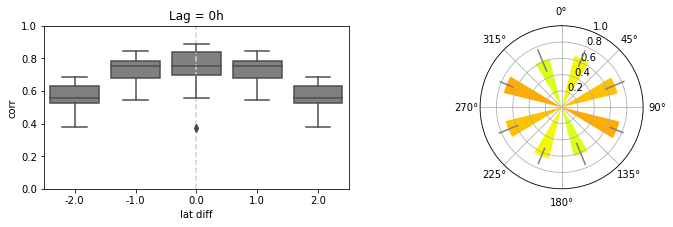

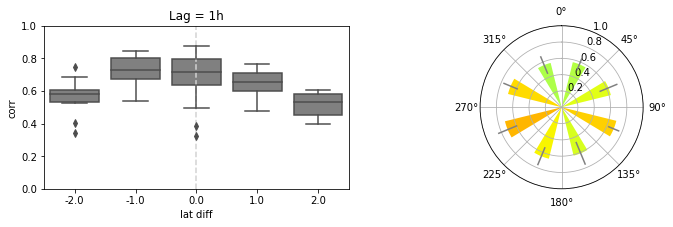

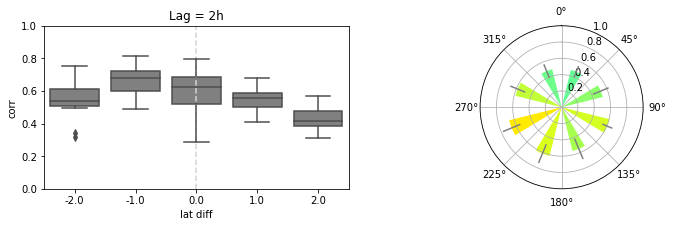

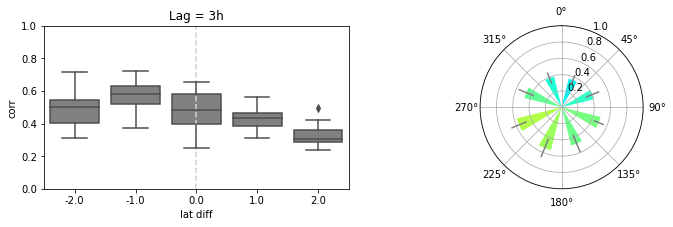

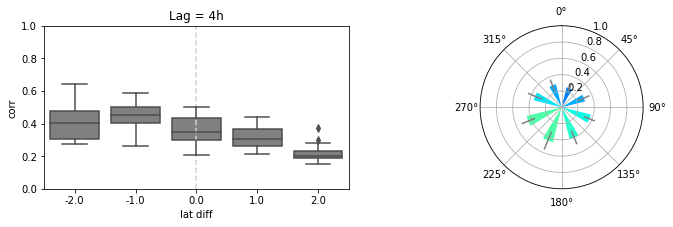

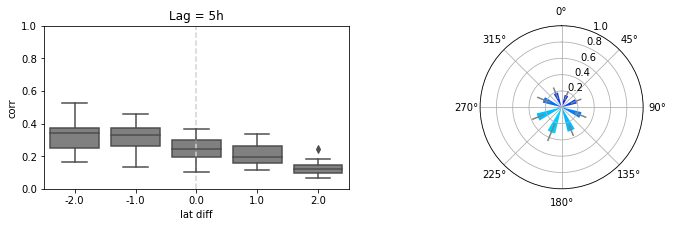

In [111]:
for lag in range(6):
    corr(vid_data, names, lag, neighbours_only=True)

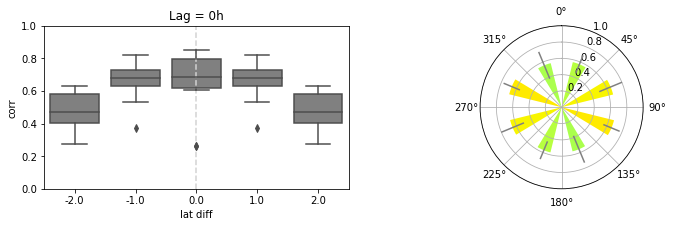

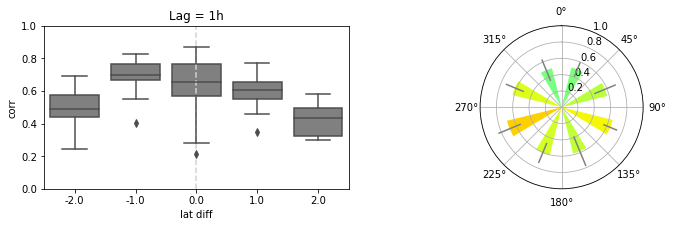

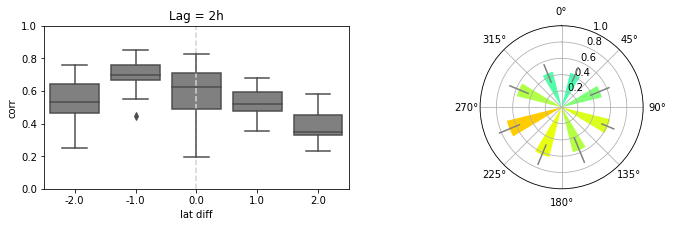

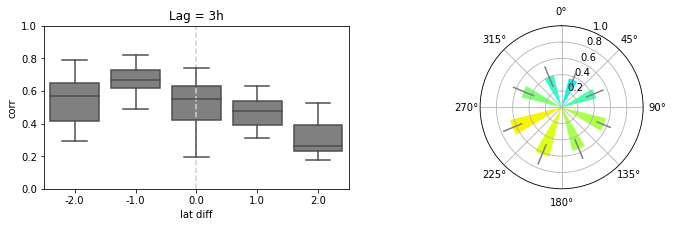

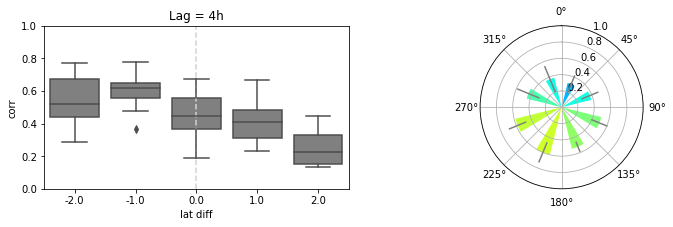

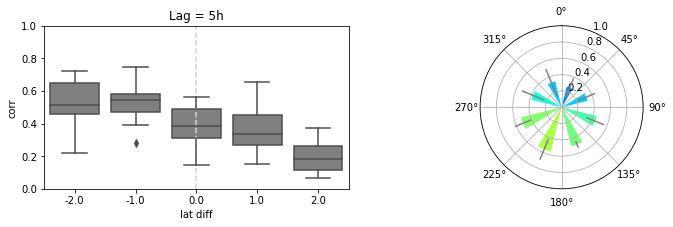

In [25]:
for lag in range(6):
    corr(vid_data, names, lag, neighbours_only=True)

### Data Transformation to Normal Distribution

In [ ]:
data = all_data(vid_data).flatten()
data[np.where(data==0)] = np.nan
data = np.power(data, 0.133)
plt.hist(data, bins=20)

### Load Data - Autumn 2018

In [ ]:
path = '/home/fiona/radar_data/vpi/night_only/20180801T0000_to_20181130T2359'
begin = '2018-09-01'
end = '2018-11-01'
var = 'vid'

files = glob.glob(os.path.join(path,'*.nc'))
vid_data_2018, names_2018, t_range_2018 = load_data(path, 'vid', begin, end, '1H')
uv_data_2018, _, _ = load_data(path, ['u', 'v'], begin, end, '1H')